# Training cats vs dogs using xception: A transfer learning experience

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
train_ds,validation_ds,test_ds = tfds.load(
    "cats_vs_dogs",
    split=['train[:40%]','train[40%:50%]','train[50%:60%]'],
    as_supervised =True,# include labels

)

print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f"Number of test samples: {test_ds.cardinality()}")

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


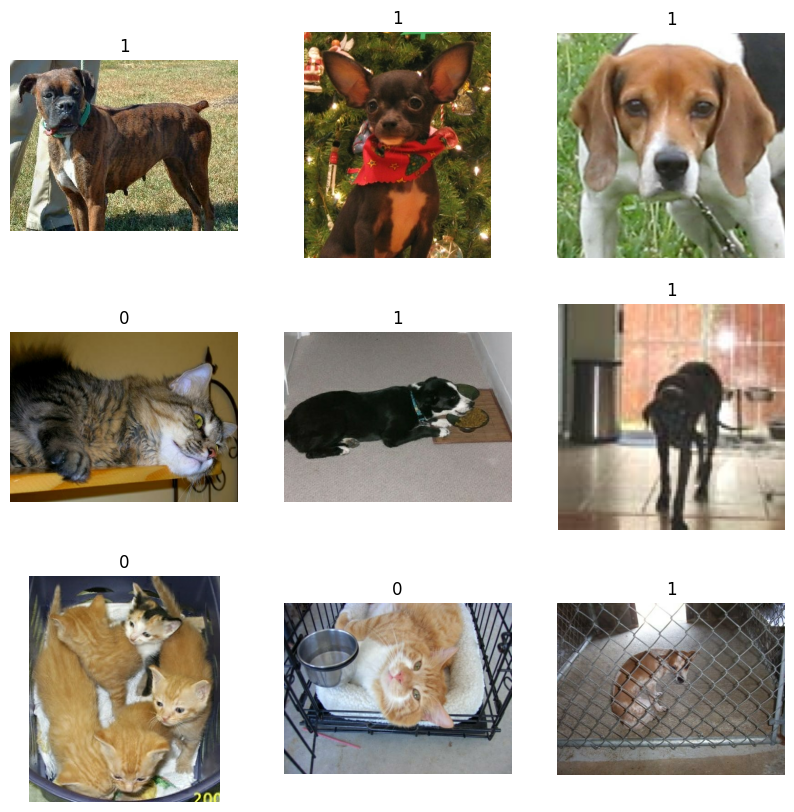

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))

for i,(image,label) in enumerate(train_ds.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image)
  plt.title(int(label))
  plt.axis("off")


### Standardizing the data

- standardizing to a fixed image size (150x150)
- Normalizing pixels between 1 and -1( using the normalization layer)

In [ ]:
resize_fn = tf.keras.layers.Resizing(150,150)

train_ds = train_ds.map(lambda x,y:(resize_fn(x),y))
validation_ds = validation_ds.map(lambda x,y:(resize_fn(x),y))
test_ds = test_ds.map(lambda x,y:(resize_fn(x),y))


### Data augmentation

- It is important if you have a small dataset to bring in diversity in the train set by applying random transformations such as horizontal flipping , small random rotations etc

In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]


def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

- For faster retrival of the data we will use batching of the data and prefetching of the data to optimize loading speeds

In [ ]:
from tensorflow import data as tf_data

batch_size = 64

train_ds = train_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
validation_ds = validation_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()
test_ds = test_ds.batch(batch_size).prefetch(tf_data.AUTOTUNE).cache()

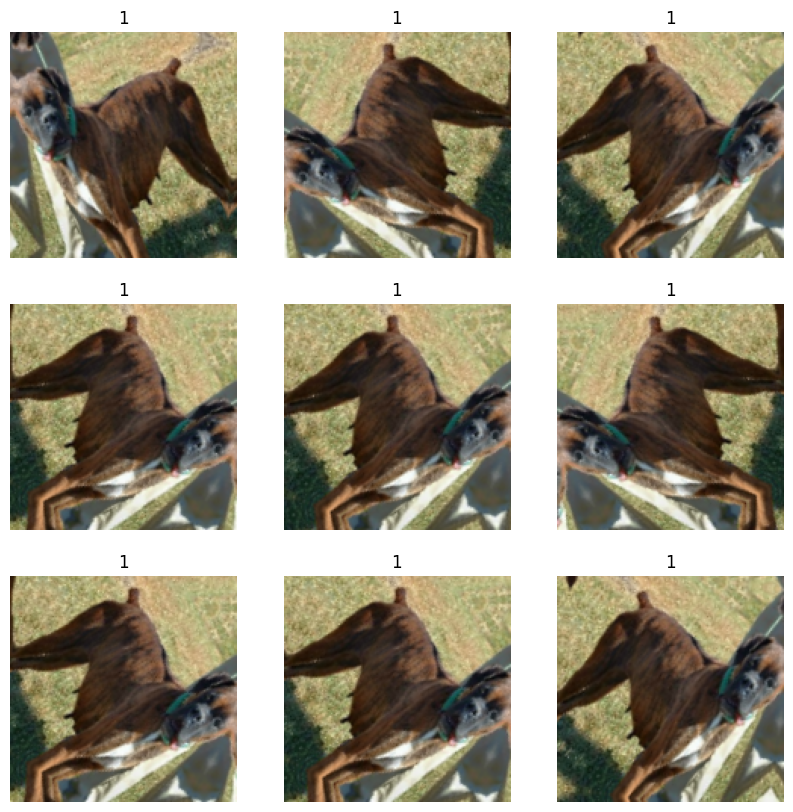

In [ ]:
# visualize the first images of the first batch
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")



## Build the model




In [ ]:
base_model = keras.applications.Xception(
    weights = "imagenet",
    input_shape = (150,150,3),
    include_top = False,
)

# freeze the base_model
base_model.trainable = False

# create new model on top
inputs = keras.Input(shape=(150,150,3))

# scaling
scale_layer = keras.layers.Rescaling(scale=1/127.5,offset = -1)
x = scale_layer(inputs)

# making sure the base model is running in inference mode

x = base_model(x,training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)

outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
model.summary(show_trainable = True)

83683744/83683744 [==============================] - 1s 0us/step
Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   N          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                         

## Train the top layer

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(),
    loss = keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = [keras.metrics.BinaryAccuracy()],
)

epochs = 2
print('Fitting the top layer of the model')
model.fit(train_ds,epochs=epochs,validation_data=validation_ds)

Fitting the top layer of the model
Epoch 1/2
146/146 [==============================] - 69s 404ms/step - loss: 0.2040 - binary_accuracy: 0.9094 - val_loss: 0.0924 - val_binary_accuracy: 0.9686
Epoch 2/2
146/146 [==============================] - 23s 154ms/step - loss: 0.1277 - binary_accuracy: 0.9459 - val_loss: 0.0828 - val_binary_accuracy: 0.9690


In [ ]:
# unfreeze the base model and train the entire model

base_model.trainable= True
model.summary(show_trainable=True)

model.compile(
    optimizer = keras.optimizers.Adam(1e-5),# low learning rate
    loss = keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = [keras.metrics.BinaryAccuracy()],


)

epochs =1

print('End to end model fine tuning')
model.fit(train_ds,epochs=epochs,validation_data = validation_ds)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        2086148   Y          
                                                       0                    
                                                                            
 global_average_pooling2d (  (None, 2048)              0         Y          
 GlobalAveragePooling2D)                                                    
                                                                            
 dropout (Dropout)           (None, 2048)              0     

## Evaluation


---



In [ ]:
model.evaluate(test_ds)

37/37 [==============================] - 5s 120ms/step - loss: 0.0674 - binary_accuracy: 0.9764


[0.06740716844797134, 0.9763542413711548]

# Part 2: Transfer learning approaches

### Approach 1: Using pretrained network as a classifier

In [ ]:
# import libraries

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16

In [ ]:
model = VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3))


553467096/553467096 [==============================] - 10s 0us/step


In [ ]:
image = load_img('/content/drive/MyDrive/dog.jpeg',target_size=(224,224))# load the image

#convert image pixels to a numpy array
image = img_to_array(image)

# reshape the image for the model

image = image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))

# preprocess the image for VGG model
image = preprocess_input(image)

In [ ]:
# predictions
yhat = model.predict(image)

label = decode_predictions(yhat)# converts the probabilies to class labels

label = label[0][0]# retrieves the most likely result with the highest probability

print('%s (%.2f%%)' % (label[1], label[2]*100))

1/1 [==============================] - 1s 610ms/step
German_shepherd (98.17%)
